In [1]:
# copy from mnist of exmaple in chainer v4.0
from __future__ import print_function

import argparse

import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions


In [2]:
import os
import numpy as np

In [3]:
train, test = chainer.datasets.get_mnist(ndim=3)

In [4]:
index_0and1 = np.logical_or(train._datasets[1] == 0, train._datasets[1] == 1)

datas = train[index_0and1]

print(len(datas[1]), len(train._datasets[1]))

train._datasets = datas
train._length = len(datas[1])

index_0and1 = np.logical_or(test._datasets[1] == 0, test._datasets[1] == 1)

datas = test[index_0and1]

print(len(datas[1]), len(test._datasets[1]))

test._datasets = datas
test._length = len(datas[1])

print(test[0][0].shape)

12665 60000
2115 10000
(1, 28, 28)


In [5]:
train[:2], test[:2]

([(array([[[0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        ],
           [0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.        , 0.        , 0.        ,
            0.        , 0.        , 0.

In [6]:
xs = [1, 2, 3]
len(xs), 2 > len(xs), 3 > len(xs)

(3, False, False)

In [7]:
# Network definition
BATCH_SIZE = 100
from chainer import ChainList, Chain
class SepLink(ChainList):
    def __init__(self, n_separate, link=L.Linear, **kwargs):
        """
            n_separate: 共用変数込みの分割サイズ
            共用, 特定クラス１, 特定クラス２, ...の順番
        """
        super(SepLink, self).__init__()
        self.n_separate = n_separate
        with self.init_scope():
            for i in range(self.n_separate):
                self.add_link(link(**kwargs))
    
    def __call__(self, xs):
        """
            xs: list of variables. eg. [common, specific class 1, specific class 2, ...]
        """
        assert len(xs) > 0
        common_x = xs[0]
        common_y = self[0](common_x)
        ys = [common_y]
        for i in range(1, self.n_separate):
            if i > len(xs) -1:
                x = common_x
            else:
                x = F.concat((common_x, xs[i]), axis=1)
            y = self[i](x)
            ys.append(y)
#         if self.input_sep_flag:
#             act_var = []
#             for i in range(self.n_separate):
#                 var = F.expand_dims(x.reshape(BATCH_SIZE, self.n_separate, -1)[:, i, :], 1)
#                 act_var.append(self[i](var))
#         else:
#             act_var = []
#             for i in range(self.n_separate):
#                 act_var.append(self[i](x))
#         res = F.concat(act_var, axis=1)
        return ys

class SepCLF(ChainList):
    def __init__(self, n_specific=2):
        super(SepCLF, self).__init__()
        self.n_specific = n_specific
        with self.init_scope():
            for i in range(self.n_specific):
                self.add_link(L.Linear(None, 1))
    
    def __call__(self, xs):
        assert 1 < len(xs)
        ys = []
        # 共用の結果は抜く
        for i, x in enumerate(xs[1:]):
            h = F.concat([xs[0], x], axis=1)
            ys.append(self[i](h))
        return ys

class SepConv(Chain):
    def __init__(self, in_channels, out_channels, n_specific=2):
        super(SepConv, self).__init__()
        with self.init_scope():
            self.conv1 = SepLink(n_separate=n_specific+1, link=L.Convolution2D,
                                in_channels=in_channels, out_channels=out_channels, ksize=3, stride=1)
#             self.l2 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=None, out_size=out_size)
#             self.l3 = SepLink(n_separate=n_specific+1, link=L.Linear, in_size=None, out_size=out_size)
            self.out = SepCLF(n_specific)
    def __call__(self, x):
        if not isinstance(x, list):
            x = [x]
#         print('x', len(x), list(map(lambda x:x.shape, x)))
        h1 = list(map(F.relu, self.conv1(x)))
#         print('h1', len(h1), list(map(lambda x:x.shape, h1)))
#         h2 = list(map(F.relu, self.l2(h1)))
#         print('h2', len(h2), list(map(lambda x:x.shape, h2)))
        _h = list(map(lambda x:F.mean(x, axis=(2, 3)), h1))
        outs = self.out(_h)
#         print('outs', len(outs), list(map(lambda x:x.shape, outs)))
        out = F.concat(outs, axis=1)
#         print('out', out.shape)
        return out

class Conv(Chain):
    def __init__(self, in_channels, out_channels, n_specific=2):
        super(Conv, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(None, out_channels, ksize=3, stride=1)
#             self.l2 = L.Linear(None, out_size)
            self.out = L.Linear(None, n_specific)
    
    def __call__(self, x):
        h1 = F.relu(self.conv1(x))
#         h2 = F.relu(self.l2(h1))
        out = self.out(F.mean(h1, axis=(2, 3)))
        return out

In [8]:
def main():
#     parser = argparse.ArgumentParser(description='Chainer example: MNIST')
#     parser.add_argument('--batchsize', '-b', type=int, default=100,
#                         help='Number of images in each mini-batch')
#     parser.add_argument('--epoch', '-e', type=int, default=20,
#                         help='Number of sweeps over the dataset to train')
#     parser.add_argument('--frequency', '-f', type=int, default=-1,
#                         help='Frequency of taking a snapshot')
#     parser.add_argument('--gpu', '-g', type=int, default=-1,
#                         help='GPU ID (negative value indicates CPU)')
#     parser.add_argument('--out', '-o', default='result',
#                         help='Directory to output the result')
#     parser.add_argument('--resume', '-r', default='',
#                         help='Resume the training from snapshot')
#     parser.add_argument('--unit', '-u', type=int, default=1000,
#                         help='Number of units')
#     args = parser.parse_args()
    args_batchsize = BATCH_SIZE
    args_epoch = 50
    args_frequency = -1
    args_gpu = 0
    args_out = 'conv_result_new'
    args_unit = 4
    vanilla_train = True
    
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    print('GPU: {}'.format(args_gpu))
    print('# unit: {}'.format(args_unit))
    print('# Minibatch-size: {}'.format(args_batchsize))
    print('# epoch: {}'.format(args_epoch))
    print('')

    # Set up a neural network to train
    # Classifier reports softmax cross entropy loss and accuracy at every
    # iteration, which will be used by the PrintReport extension below.
    in_size = None
    args_unit
#     model = L.Classifier(SepMLP(in_size, out_size))
    model = L.Classifier(Conv(None, out_channels=int(args_unit*3)))
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    if vanilla_train:
        print('training vanilla')
        chainer.serializers.save_npz(args_out +'/vanilla-base.model', model)
        trainer.run()
        chainer.serializers.save_npz(args_out +'/vanilla.model', model)

    args_out = 'sep_'+ args_out
    if not os.path.exists(args_out):
        os.makedirs(args_out)
    model = L.Classifier(SepConv(None, out_channels=args_unit))
    print(model.predictor.conv1.n_separate)
    if args_gpu >= 0:
        # Make a specified GPU current
        chainer.backends.cuda.get_device_from_id(args_gpu).use()
        model.to_gpu()  # Copy the model to the GPU

    # Setup an optimizer
    optimizer = chainer.optimizers.Adam()
    optimizer.setup(model)

    # Load the MNIST dataset
#     train, test = chainer.datasets.get_mnist()

    train_iter = chainer.iterators.SerialIterator(train, args_batchsize)
    test_iter = chainer.iterators.SerialIterator(test, args_batchsize,
                                                 repeat=False, shuffle=False)

    # Set up a trainer
    updater = training.updaters.StandardUpdater(
        train_iter, optimizer, device=args_gpu)
    trainer = training.Trainer(updater, (args_epoch, 'epoch'), out=args_out)

    # Evaluate the model with the test dataset for each epoch
    trainer.extend(extensions.Evaluator(test_iter, model, device=args_gpu))

    # Dump a computational graph from 'loss' variable at the first iteration
    # The "main" refers to the target link of the "main" optimizer.
    trainer.extend(extensions.dump_graph('main/loss'))

    # Take a snapshot for each specified epoch
    frequency = args_epoch if args_frequency == -1 else max(1, args_frequency)
    trainer.extend(extensions.snapshot(), trigger=(frequency, 'epoch'))

    trainer.extend(extensions.LogReport())
    trainer.extend(
        extensions.PlotReport(['main/loss', 'validation/main/loss'],
                              'epoch', file_name='loss.png'))
    trainer.extend(
        extensions.PlotReport(
            ['main/accuracy', 'validation/main/accuracy'],
            'epoch', file_name='accuracy.png'))

    trainer.extend(extensions.PrintReport(
        ['epoch', 'main/loss', 'validation/main/loss',
         'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

    trainer.extend(extensions.ProgressBar())


    # Run the training
    print('training two separated model')
    chainer.serializers.save_npz(args_out +'/sep-base.model', model)
    trainer.run()
    chainer.serializers.save_npz(args_out +'/sep.model', model)

In [9]:
main()

GPU: 0
# unit: 4
# Minibatch-size: 100
# epoch: 50

training vanilla
epoch       main/loss   validation/main/loss  main/accuracy  validation/main/accuracy  elapsed_time
     total [..................................................]  1.58%
this epoch [#######################################...........] 78.96%
       100 iter, 0 epoch / 50 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
1           0.699793    0.665365              0.614173       0.937727                  1.84985       
     total [#.................................................]  3.16%
this epoch [############################......................] 57.92%
       200 iter, 1 epoch / 50 epochs
    139.23 iters/sec. Estimated time to finish: 0:00:44.046523.
2           0.614024    0.564154              0.900709       0.909546                  2.65247       
     total [##................................................]  4.74%
this epoch [##################................................] 36.87%
      

20          0.104715    0.104128              0.965          0.965909                  16.3632       
     total [####################..............................] 41.06%
this epoch [##########################........................] 52.90%
      2600 iter, 20 epoch / 50 epochs
    164.79 iters/sec. Estimated time to finish: 0:00:22.649408.
21          0.101109    0.100387              0.966063       0.968182                  17.1211       
     total [#####################.............................] 42.64%
this epoch [###############...................................] 31.86%
      2700 iter, 21 epoch / 50 epochs
    164.13 iters/sec. Estimated time to finish: 0:00:22.131198.
22          0.0970618   0.0954248             0.968032       0.969091                  17.8868       
     total [######################............................] 44.22%
this epoch [#####.............................................] 10.82%
      2800 iter, 22 epoch / 50 epochs
    163.05 iters/sec. Esti

40          0.054881    0.0502106             0.983254       0.985                     31.7424       
     total [########################################..........] 80.54%
this epoch [#############.....................................] 26.85%
      5100 iter, 40 epoch / 50 epochs
    164.22 iters/sec. Estimated time to finish: 0:00:07.505340.
41          0.0536466   0.0485865             0.983859       0.985454                  32.5166       
     total [#########################################.........] 82.12%
this epoch [##................................................]  5.80%
      5200 iter, 41 epoch / 50 epochs
    163.84 iters/sec. Estimated time to finish: 0:00:06.912267.
     total [#########################################.........] 83.70%
this epoch [##########################################........] 84.76%
      5300 iter, 41 epoch / 50 epochs
    165.15 iters/sec. Estimated time to finish: 0:00:06.251890.
42          0.0525506   0.0469923             0.984961       0.9

     total [#########.........................................] 18.95%
this epoch [#######################...........................] 47.49%
      1200 iter, 9 epoch / 50 epochs
    97.739 iters/sec. Estimated time to finish: 0:00:52.512559.
10          0.194227    0.192317              0.948819       0.949091                  12.5644       
     total [##########........................................] 20.53%
this epoch [#############.....................................] 26.45%
      1300 iter, 10 epoch / 50 epochs
    97.443 iters/sec. Estimated time to finish: 0:00:51.645348.
11          0.180022    0.179871              0.949134       0.949545                  13.8197       
     total [###########.......................................] 22.11%
this epoch [##................................................]  5.41%
      1400 iter, 11 epoch / 50 epochs
     97.25 iters/sec. Estimated time to finish: 0:00:50.719914.
     total [###########.......................................] 2

29          0.114712    0.118164              0.95754        0.958182                  36.8071       
     total [#############################.....................] 58.43%
this epoch [##########........................................] 21.44%
      3700 iter, 29 epoch / 50 epochs
    98.598 iters/sec. Estimated time to finish: 0:00:26.699287.
30          0.113352    0.11657               0.957795       0.957727                  38.0612       
     total [##############################....................] 60.01%
this epoch [..................................................]  0.39%
      3800 iter, 30 epoch / 50 epochs
    98.492 iters/sec. Estimated time to finish: 0:00:25.712751.
     total [##############################....................] 61.59%
this epoch [#######################################...........] 79.35%
      3900 iter, 30 epoch / 50 epochs
    99.131 iters/sec. Estimated time to finish: 0:00:24.538122.
31          0.112471    0.115404              0.957559       0.9

     total [################################################..] 97.91%
this epoch [###############################################...] 95.38%
      6200 iter, 48 epoch / 50 epochs
    99.241 iters/sec. Estimated time to finish: 0:00:01.335129.
49          0.0844139   0.0845638             0.969524       0.971818                  62.328        
     total [#################################################.] 99.49%
this epoch [#####################################.............] 74.34%
      6300 iter, 49 epoch / 50 epochs
    99.177 iters/sec. Estimated time to finish: 0:00:00.327698.
50          0.0824237   0.0819192             0.971181       0.972273                  63.5738       


In [12]:
in_size = None
out_size = 4
vanilla_model = L.Classifier(Conv(in_size, int(out_size*3)))
sep_model = L.Classifier(SepConv(in_size, out_size))
chainer.serializers.load_npz('./conv_result_new/vanilla.model', vanilla_model)
chainer.serializers.load_npz('./sep_conv_result_new/sep.model', sep_model)

In [13]:
van_mlp = vanilla_model.predictor
print(van_mlp.conv1.W.shape)

sep_mlp = sep_model.predictor
for i in range(sep_mlp.conv1.n_separate):
    print(sep_mlp.conv1[i].W.shape)

(12, 1, 3, 3)
(4, 1, 3, 3)
(4, 1, 3, 3)
(4, 1, 3, 3)


In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

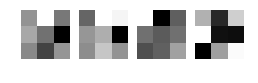

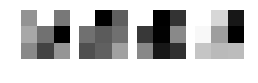

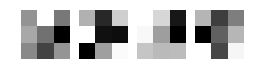

In [18]:
n_row = 1
n_col = out_size
for i in range(1, 3+1):
    plt.figure(figsize=(n_col, n_row))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(van_mlp.conv1.W.data[int(i*j)].reshape(3, 3), cmap='gray')
        plt.axis('off')
    plt.show()

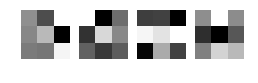

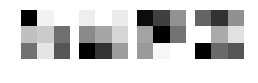

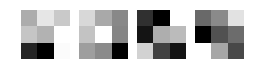

In [19]:
n_row = 1
n_col = out_size
for i in range(1, 3+1):
    plt.figure(figsize=(n_col, n_row))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(sep_mlp.conv1[i-1].W.data[j].reshape(3, 3), cmap='gray')
        plt.axis('off')
    plt.show()

[[ 8.1599933e-01 -2.9867532e+00  5.9458572e-01 -2.8612683e+00
   1.4293817e+00  3.6262946e+00  2.3044739e+00 -3.6755693e+00
  -2.5309732e+00 -4.0232041e-01  4.0284085e+00 -1.6493386e-03]
 [-1.4298024e+00  3.4877481e+00 -8.5661167e-01  2.6006322e+00
  -1.0200181e+00 -3.6721628e+00 -2.5348041e+00  3.6502161e+00
   2.7194810e+00  1.8548207e-01 -3.9316077e+00  1.8512177e-01]]


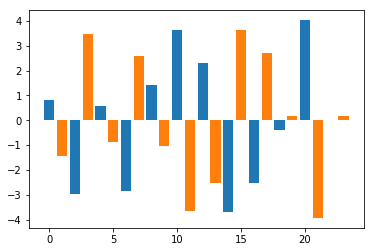

In [21]:
print(van_mlp.out.W.data)
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*2, van_mlp.out.W.data[0])
plt.bar(np.arange(len(van_mlp.out.W.data[0]))*2+1, van_mlp.out.W.data[1])
plt.show()

[[-0.4393744  -2.3226326  -2.3833895  -3.8336663   0.67354447  4.7495666
  -0.40434277  1.4470971 ]]


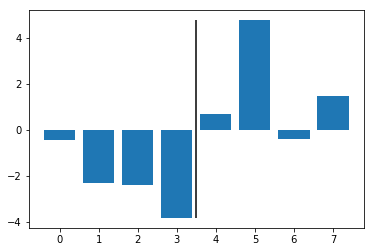

In [23]:
i = 0
print(sep_mlp.out[i].W.data)
plt.bar(np.arange(len(sep_mlp.out[i].W.data[0])), sep_mlp.out[i].W.data[0])
ymax = sep_mlp.out[i].W.data.max()
ymin = sep_mlp.out[i].W.data.min()
plt.vlines(out_size - .5 , ymin=ymin, ymax=ymax)
plt.show()

[[ 0.03221    1.9363908  2.8473654  3.5279872 -1.113193   1.842841
  -1.7383653 -1.6820861]]


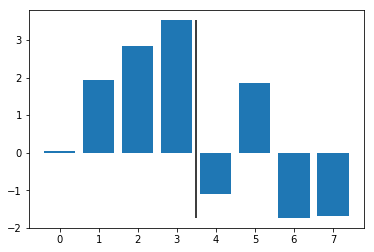

In [24]:
i = 1
print(sep_mlp.out[i].W.data)
plt.bar(np.arange(len(sep_mlp.out[i].W.data[0])), sep_mlp.out[i].W.data[0])
ymax = sep_mlp.out[i].W.data.max()
ymin = sep_mlp.out[i].W.data.min()
plt.vlines(out_size - .5 , ymin=ymin, ymax=ymax)
plt.show()

In [25]:
test_data = test[:2]

In [26]:
test_image = np.asarray(list(map(lambda x: x[0], test_data)))
test_label = np.asarray(list(map(lambda x: x[1], test_data)))

In [40]:
van_feature_map = van_mlp.conv1(test_image)
van_outs = van_mlp(test_image)
sep_feature_map = sep_mlp.conv1([test_image])
sep_outs = sep_mlp(test_image)

In [41]:
van_feature_map.shape, van_outs.shape

((2, 12, 26, 26), (2, 2))

In [29]:
def norm(x):
    h = x.copy()
    h = h - h.min()
    h = h / h.max()
    return h

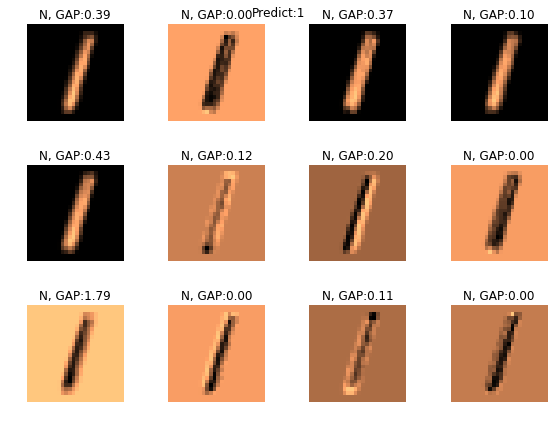

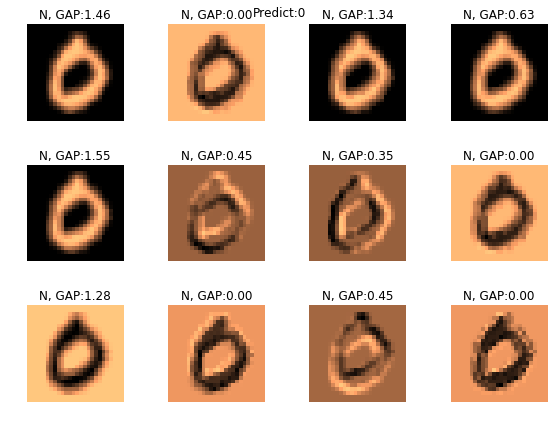

In [50]:
n_row = 3
n_col = out_size
for i in range(1, 2+1):
    plt.figure(figsize=(n_col*2, n_row*2))
    for j in range(int(n_row*n_col)):
        plt.subplot(n_row, n_col, j+1)
        plt.imshow(norm(van_feature_map.data)[i-1, j, :], cmap='copper')
        gap = np.mean(np.maximum(van_feature_map.data[i-1, j, :], 0))
        plt.title('{}, GAP:{:.2f}'.format('N', gap))
        plt.axis('off')
    
    plt.suptitle('Predict:{}'.format(np.argmax(van_outs.data[i-1])))
    plt.tight_layout()
    plt.show()

In [51]:
len(sep_feature_map), sep_feature_map[0].shape

(3, (2, 4, 26, 26))

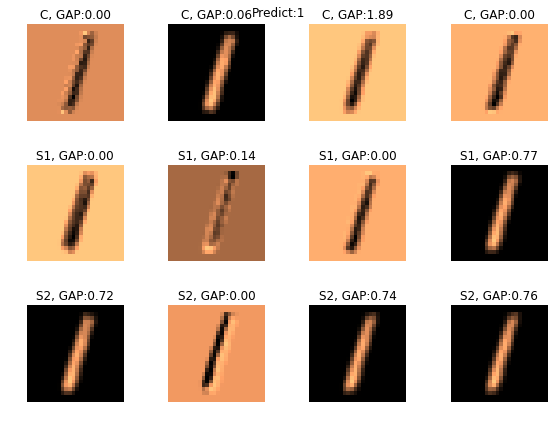

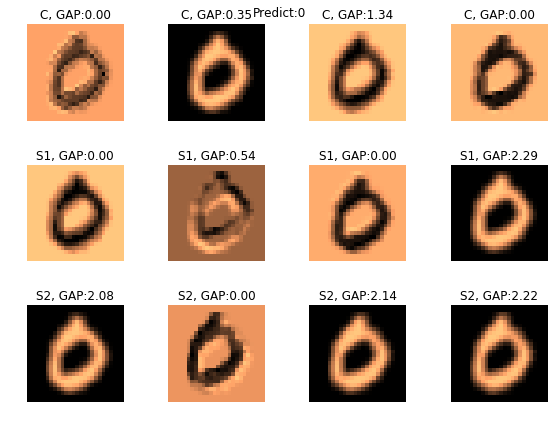

In [52]:
n_row = 3
n_col = out_size
for i in range(1, 2+1):
    plt.figure(figsize=(n_col*2, n_row*2))
    for n in range(n_row):
        if n == 0:
            sign = 'C'
        else:
            sign = 'S{}'.format(n)
        for j in range(n_col):
            plt.subplot(n_row, n_col, out_size*n + j+1)
            plt.imshow(norm(sep_feature_map[n].data)[i-1, j, :], cmap='copper')
            gap = np.mean(np.maximum(sep_feature_map[n].data[i-1, j, :], 0))
            plt.title('{}, GAP:{:.2f}'.format(sign, gap))
            plt.axis('off')
    plt.suptitle('Predict:{}'.format(np.argmax(van_outs.data[i-1])))
    plt.tight_layout()
    plt.show()

# 出力に使われている奴を見る

In [84]:
print(np.round(van_mlp.out.W.data, 2))
print('')
for o in sep_mlp.out:
    print(np.round(o.W.data, 2))

[[ 0.82 -2.99  0.59 -2.86  1.43  3.63  2.3  -3.68 -2.53 -0.4   4.03 -0.  ]
 [-1.43  3.49 -0.86  2.6  -1.02 -3.67 -2.53  3.65  2.72  0.19 -3.93  0.19]]

[[-0.44 -2.32 -2.38 -3.83  0.67  4.75 -0.4   1.45]]
[[ 0.03  1.94  2.85  3.53 -1.11  1.84 -1.74 -1.68]]


In [63]:
batch_size = 2
n_specific = 2

In [80]:
for n in range(batch_size):
    print(test_label[n])
    for i in range(n_specific):
        w_data = van_mlp.out.W.data[i]
        gap = np.mean(np.maximum(van_feature_map.data[n], 0), axis=(1, 2))
        z = w_data * gap
        print(np.round(z, 2), np.sum(z))

1
[ 0.32 -0.    0.22 -0.29  0.61  0.42  0.45 -0.   -4.52 -0.    0.44 -0.  ] -2.3586185
[-0.56  0.01 -0.32  0.27 -0.43 -0.43 -0.5   0.    4.85  0.   -0.43  0.  ] 2.4661953
0
[ 1.19 -0.01  0.8  -1.81  2.21  1.64  0.81 -0.   -3.23 -0.    1.83 -0.  ] 3.4316552
[-2.09  0.01 -1.15  1.65 -1.58 -1.66 -0.89  0.    3.47  0.   -1.79  0.  ] -4.0261273


In [81]:
for n in range(batch_size):
    print(test_label[n])
    for i in range(n_specific):
        w_data = sep_mlp.out[i].W.data
        common_gap = np.mean(np.maximum(sep_feature_map[0].data[n], 0), axis=(1, 2))
        gap = np.mean(np.maximum(sep_feature_map[i+1].data[n], 0), axis=(1, 2))
#         print(common_gap.shape, gap.shape)
        gap = np.concatenate((common_gap, gap), axis=0)
        z = w_data * gap
        print(np.round(z, 2), np.sum(z))

1
[[-0.   -0.14 -4.5  -0.01  0.    0.64 -0.    1.12]] -2.8766665
[[ 0.    0.12  5.37  0.   -0.8   0.   -1.28 -1.27]] 2.1412282
0
[[-0.   -0.81 -3.18 -0.    0.    2.55 -0.    3.31]] 1.860373
[[ 0.    0.68  3.8   0.   -2.32  0.01 -3.73 -3.74]] -5.291238
